# Chapter 02: Visualising Gradient Descent

## Introduction

In the last project, we made use of the Stochastic Gradient Descent Classifier to try and classify football based on match statistics. We didn't have much success, and it was difficult to clearly understanding why this was without a detailed understanding of how gradient descent works. The first half of Chapter 4 in Geron goes into gradient descent in a decent amount of detail, and I want to use this project to use the information in that section to do some experimentation with applying gradient descent algorithms to binary classification problems. 

## Getting the Data

The data we'll use for this project is the [Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci) dataset. The data contains demographic and health attributes for 303 individuals and a binary classification denoting the presence of heart disease.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

data=pd.read_csv("C:/Users/tomra/Desktop/ml_ipynb/heart_disease/heart-disease-uci/heart.csv")
#according to discussion in the Kaggle project, the target variable has somehow ended up inverted and needs to be amended
data["target"]=1-data["target"]

In [2]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


Examining correlations with "target", we can see that serveral variables show strong statistical relationships:

In [4]:
corr_matrix=data.corr()

print(corr_matrix["target"].sort_values(ascending=False))

target      1.000000
exang       0.436757
oldpeak     0.430696
ca          0.391724
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg    -0.137230
slope      -0.345877
thalach    -0.421741
cp         -0.433798
Name: target, dtype: float64


For present purposes we'll select just a few of these. I want to use non-categorical variables for the sake of simplicity (although I do need to have a proper look at OneHotEncoder at some point) and for that reason selected the below, referring to "maximum heart rate" (obtained during exercise), "number of  vessels colored by flourosopy" and "ST depression induced by exercise":

In [5]:
data=data[["thalach", "ca", "oldpeak", "target"]].rename(columns={"thalach":"max_heart_rate", "ca":"n_flourosopy", "oldpeak":"st_depression"})

Boxplots indicate that our explanitatory variables have quite different distributions depending on the presence of heart disease, which should aid classification:

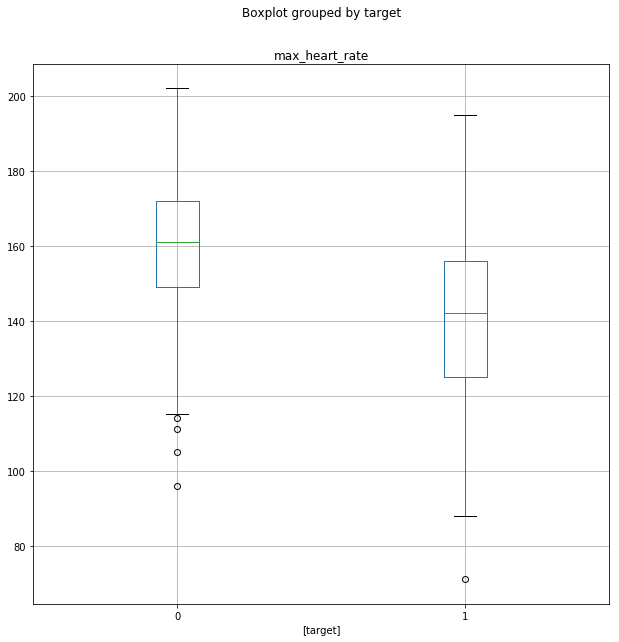

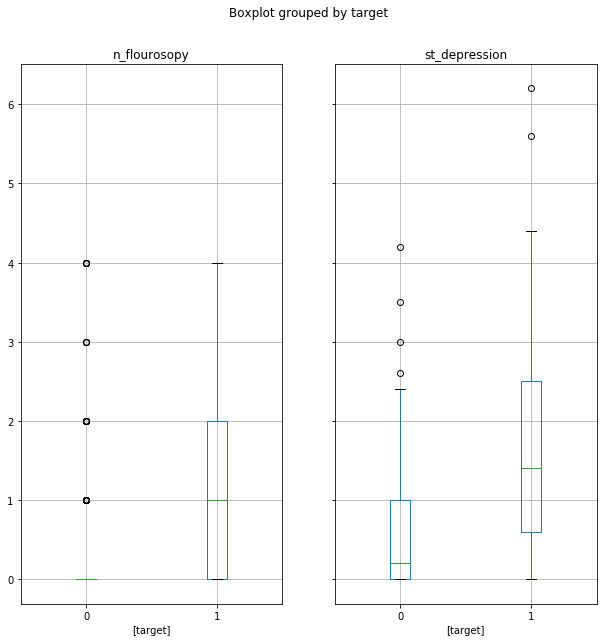

In [6]:
boxplot = data[["max_heart_rate", "target"]].boxplot(by='target',  showfliers=True, figsize=(10,10))
boxplot = data[["n_flourosopy", "st_depression","target"]].boxplot(by='target',  showfliers=True, figsize=(10,10) )

Plotting in 3d further demonstrates that we should have fairly distinct decision boundries: heart disease instances generally exist in a region bounded by n_flourosopy>0,st_depression>0, maximum_heart_rate<150:

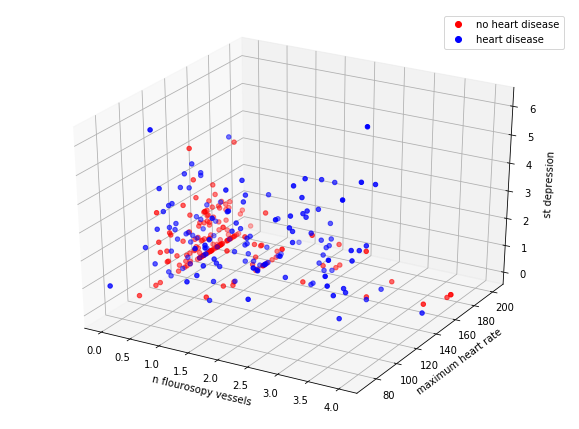

In [7]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib
import matplotlib.pyplot as plt


colors = ['red','blue']

fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(data["n_flourosopy"], data["max_heart_rate"], data["st_depression"], c=data["target"],cmap=matplotlib.colors.ListedColormap(colors))

scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['no heart disease', 'heart disease'], numpoints = 1)


plt.xlabel('n flourosopy vessels')
plt.ylabel('maximum heart rate')
ax.set_zlabel('st depression')

plt.show()

Splitting out training and testing data:

In [8]:
#random sampling
data=data.sample(frac=1)
msk = np.random.rand(len(data)) < 0.8

#splitting out training and testing sets
train = data[msk]
test = data[~msk]

#splitting out X/y
X_train=np.array(train[["n_flourosopy", "max_heart_rate", "st_depression"]])
y_train=np.array(train[["target"]])

X_test=np.array(test[["n_flourosopy", "max_heart_rate", "st_depression"]])
y_test=np.array(test[["target"]]).squeeze()

## Training Batch Gradient Descent

We're going to use a manually-coded logistic regression classifier to investigate some properties of gradient descent. This implementation borrows somewhat from [Martin Pellarolo's implementation for Medium.com](https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac):

In [9]:
#Gives estimated probability of y=1 as the dot product of input variables and weightings plus intercept term for each row.
#i.e. X(1)*W(1)+X(2)*W(2)+...+X(n)W(n)+b=Z for all m rows. 
def sigmoid(Z):
    return 1/ (1+np.e**(-Z))

#convex function returning logged difference between y=1 probability and correct value
def logistic_loss(y, y_hat):
    return -np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))

#n-space directional slope maxima of logistic loss
def gradient(m, dz, X):
    return 1/m*np.matmul(X.T, dz)

def BGD_Train(n_iterations, learning_rate, X, y):
    
    #inititalising weights to zero
    W=np.zeros((X.shape[1],1))
    Ws=np.empty((X.shape[1],0))

    #initialising intercept to zero
    b=np.zeros((1,1))
    bs=np.empty((1,0))

    losses=[]

    #number of rows
    m=y.shape[0]

    for iter in range(n_iterations):
        
        #data/weights dot product
        Z=np.matmul(X, W)+ b
        #estimated probability of y=1
        A=sigmoid(Z)
        
        #loss function
        loss=logistic_loss(y, A)
        #difference between probability and actual y-value
        dz=A-y
        #weighting update gradient
        dw=gradient(m, dz, X)
        #intercept update gradient
        db=np.sum(dz)
        
        #updating weighting and gradient
        W=W-learning_rate*dw
        b=b-learning_rate*db

        #concatenating weights and losses for visualisation
        Ws= np.concatenate((Ws, W), axis=1)
        bs=np.concatenate((bs, b), axis=1)  
        losses.extend([loss])
    
    df=pd.DataFrame(Ws.T)
    df.columns=[ [('theta_' + str(num+1)) for num in range(3)]]
    df['b']=bs.T
    df['loss']=losses
    
    return df

def visualise(df):
   
    plt.plot(df.loc[:, 'theta_1'], color='red', label='theta_1')
    plt.plot(df.loc[:, 'theta_2'], color='blue', label='theta_2')
    plt.plot(df.loc[:, 'theta_3'], color='yellow', label='theta_3')
    plt.plot(df.loc[:, 'b'], color='green', label='b')
    plt.plot(df.loc[:, 'loss'], color='purple', label='loss')
    plt.legend()
    plt.title('Batch Descent Parameter Estimations Across Iterations')
    plt.xlabel('n_iterations')
    plt.ylabel('theta, loss')


The above will return a dataframe containing each iteration's parameter estimations and logistic loss, and then visualise. We expect the parameter estimations to converge non-linearly to a particular value and then level off and the logistic loss function to reduce proportionally. Running with an initial set of values:

C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


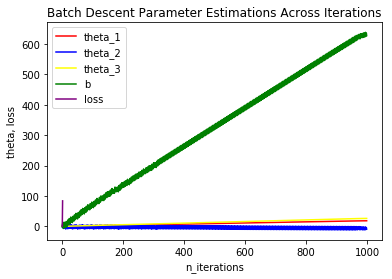

In [151]:
df=BGD_Train(n_iterations=1000, learning_rate=0.1, X=X_train, y=y_train)

visualise(df)

This is not what we hoped for. The figures are variously sitting at zero, zig-zagging or ceaselessly trending upwards. The warnings seem to suggest that some of the mathemetical operations are returning or being passed arbitrarily large or small values. 

I'm going to try running a debug version which prints values:

In [102]:
def BGD_Train_debug1(n_iterations, learning_rate, X, y):
    
    #inititalising weights to zero
    W=np.zeros((X.shape[1],1))
    
    #initialising intercept to zero
    b=np.zeros((1,1))
   

    #number of rows
    m=y.shape[0]

    for iter in range(n_iterations):
        
        #data/weights dot product
        Z=np.matmul(X, W)+ b
        #estimated probability of y=1
        A=sigmoid(Z)
        #print value returned by sigmoid
        print(A)
        #loss function
        loss=logistic_loss(y, A)
        #difference between probability and actual y-value
        dz=A-y
        #weighting update gradient
        dw=gradient(m, dz, X)
        #intercept update gradient
        db=np.sum(dz)
        
        #updating weighting and gradient
        W=W-learning_rate*dw
        b=b-learning_rate*db

BGD_Train_debug1(n_iterations=10, learning_rate=0.01, X=X_train, y=y_train)

[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]

C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


The sigmoid is returning values which are either 1 or arbitrarily small. This suggests that the function itself is being passed values from the dot product which are either very positive (making the negative exponential very small, so that the sigmoid returns 1) or very negative (making the exponential very large, making the sigmoid very small). Taking a look:

In [117]:
def BGD_Train_debug2(n_iterations, learning_rate, X, y):
    
    #inititalising weights to zero
    W=np.zeros((X.shape[1],1))
    
    #initialising intercept to zero
    b=np.zeros((1,1))
   

    #number of rows
    m=y.shape[0]

    for iter in range(n_iterations):
        
        #data/weights dot product
        Z=np.matmul(X, W)+ b
        #estimated probability of y=1
        A=sigmoid(Z)
        #print value passed to sigmoid
        print(Z)
        #loss function
        loss=logistic_loss(y, A)
        #difference between probability and actual y-value
        dz=A-y
        #weighting update gradient
        dw=gradient(m, dz, X)
        #intercept update gradient
        db=np.sum(dz)
        
        #updating weighting and gradient
        W=W-learning_rate*dw
        b=b-learning_rate*db

BGD_Train_debug2(n_iterations=10, learning_rate=0.01, X=X_train, y=y_train)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


These aren't enormous values on the face of it, but they are clearly enough to generate values that Python is not happy with and to prevent the algorithm from converging. The solution then seems to be to scale X using a sensible method, and for that we can use StandardScaler as in the last project:

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([        
        ('std_scaler', StandardScaler()),        
    ])
X_pipe = num_pipeline.fit_transform(X_train)

X_pipe

array([[ 2.18338267e+00,  1.02072832e+00, -8.97021048e-01],
       [ 2.54869572e-01,  9.16063222e-02, -4.59684755e-01],
       [-7.09386975e-01, -5.27808342e-01, -8.97021048e-01],
       [-7.09386975e-01,  3.11851310e-03, -8.97021048e-01],
       [-7.09386975e-01, -2.62344914e-01,  1.55206219e+00],
       [-7.09386975e-01,  1.02072832e+00, -8.97021048e-01],
       [-7.09386975e-01, -1.45693034e+00,  2.07686574e+00],
       [ 1.21912612e+00, -1.32419862e+00,  6.77389606e-01],
       [ 1.21912612e+00, -7.49027864e-01,  2.60166929e+00],
       [ 2.18338267e+00, -1.94361329e+00,  7.64856865e-01],
       [-7.09386975e-01,  8.43752700e-01, -8.97021048e-01],
       [-7.09386975e-01, -1.19146691e+00, -3.72217497e-01],
       [-7.09386975e-01,  1.64014298e+00,  2.16433300e+00],
       [-7.09386975e-01,  1.41892346e+00,  2.42673478e+00],
       [-7.09386975e-01,  4.45557559e-01,  6.77389606e-01],
       [-7.09386975e-01, -6.16296151e-01, -8.97021048e-01],
       [-7.09386975e-01,  8.43752700e-01

Retrying:

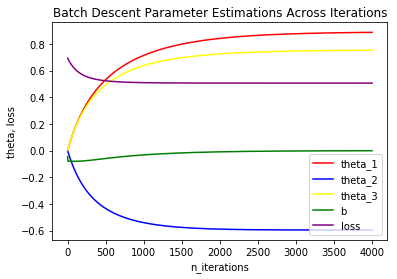

In [11]:
df=BGD_Train(n_iterations=4000, learning_rate=0.01, X=X_pipe, y=y_train)

visualise(df)

This looks much better - we can clearly see the estimations converging upon values, and in doing so reducing the loss. 

Before we test the parameters, it would be good to look at one or two more learning rates:

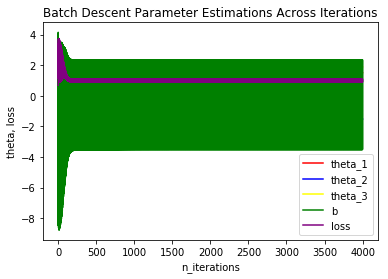

In [153]:
df=BGD_Train(n_iterations=4000, learning_rate=0.1, X=X_pipe, y=y_train)

visualise(df)

This is interesting: increasing the learning rate prevents the algorithm from converging entirely - it just darts around without proceding down the loss function. 

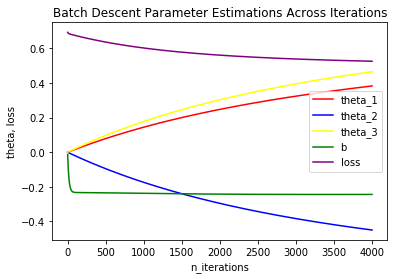

In [154]:
df=BGD_Train(n_iterations=4000, learning_rate=0.001, X=X_pipe, y=y_train)

visualise(df)

As expected, decreasing the loss function does not prevent the algorithm from working, but it is going to take longer to converge. 

## Testing Batch Gradient Descent

We now have the below estimates:

In [12]:
df=BGD_Train(n_iterations=4000, learning_rate=0.01, X=X_pipe, y=y_train)

theta_1=float(df["theta_1"].iloc[-1, :])
theta_2=float(df["theta_2"].iloc[-1, :])
theta_3=float(df["theta_3"].iloc[-1, :])
b=float(df["b"].iloc[-1, :])

print(theta_1)
print(theta_2)
print(theta_3)
print(b)

0.8864318514407425
-0.5943796722796093
0.7526560003268722
-0.0002870211087726611


We'll first create a function to fit values:

In [13]:
def gradient_descent_fit(test_data, y, parms, threshold):
    
    Z=np.matmul(test_data, parms)+ b
    X_test_prob=sigmoid(Z)    
    X_test_decision=(X_test_prob>threshold).astype('int')
    df=test.reset_index()
    df['prob']=X_test_prob
    df['decision']=X_test_decision.astype(int)
    df['test']=(df.target==df.decision)
    return df

A preliminary look at how we did:

In [14]:
#transforming test data
X_test_pipe = num_pipeline.fit_transform(X_test)

#list of parameters
thetas=[theta_1, theta_2, theta_3]

#calling
X_decision_df= gradient_descent_fit(X_test_pipe, y_test, thetas, 0.5)
X_decision_df.head(20)

,index,max_heart_rate,n_flourosopy,st_depression,target,prob,decision,test
0,277,141,0,0.3,1,0.280666,0,False
1,60,130,1,0.0,0,0.515295,1,False
2,151,125,0,1.6,0,0.568043,1,False
3,275,168,2,1.0,1,0.655443,1,True
4,214,144,1,1.2,1,0.612746,1,True
5,202,111,0,0.8,1,0.531503,1,True
6,297,90,2,1.0,1,0.931227,1,True
7,127,172,1,0.0,0,0.269806,0,True
8,79,154,0,0.6,0,0.253358,0,True
9,85,160,0,1.6,0,0.352789,0,True


It looks like we are correct more often than not, but far from perfect. Checking a few key performance metrics:


In [15]:
def key_performance(df): 
    print('accuracy: ',sum(df.test)/len(df))

    TP=((df.target==1) & (df.decision==1))
    FP=((df.target==1) & (df.decision==0))
    TN=((df.target==0) & (df.decision==0))
    FN=((df.target==0) & (df.decision==1))

    precision=sum(TP)/(sum(TP)+sum(FP))
    print('precision: ', precision)

    recall=sum(TP)/(sum(TP)+sum(FN))
    print('recall: ', recall)
    
    print('F1 score: ', (2*precision*recall)/(precision+recall))
    
key_performance(X_decision_df)


accuracy:  0.8289473684210527
precision:  0.8620689655172413
recall:  0.7352941176470589
F1 score:  0.7936507936507937


Based on the above, we can say that out model correctly classified 82.9% of the time, that 86.2% of those classified as having heart disease did in fact have it, and that 73.5% of those with heart disease were identified. 

I'm interested in seeing the effects of different decision threshold values on model performance - although 0.5 is intuitive, it might not yield the best results. We'll create a function to examine different theshold values:

C:\Users\tomra\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


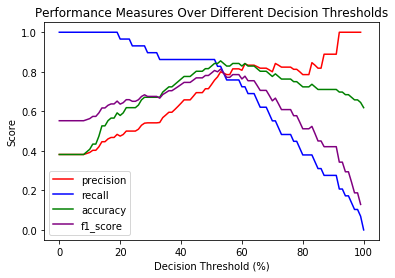

In [17]:
def threshold_test(test_data, y_test):

    acc_list=[]
    prec_list=[]
    rec_list=[]
    f1_list=[]

    for threshold in np.linspace(0, 1, 101):
   
        Z=np.matmul(test_data, thetas)+ b
        X_test_prob=sigmoid(Z)  

        X_test_decision=(X_test_prob>threshold).astype('int')   
        accuracy=[sum(X_test_decision == y_test)/y_test.size]
        acc_list.extend(accuracy)

        TP=sum((X_test_decision==1)&(y_test==1))
        FP=sum((X_test_decision==1)&(y_test==0))
        FN=sum((X_test_decision==0)&(y_test==1))   

        precision=TP/(TP+FP)
        prec_list.extend([precision])           
      
        recall=TP/(TP+FN)
        rec_list.extend([recall])
     
        F1=(2*precision*recall)/(precision+recall)
        f1_list.extend([F1])

    return prec_list, rec_list, acc_list, f1_list

prec_list, rec_list, acc_list, f1_list=threshold_test(X_test_pipe, y_test)

plt.plot(prec_list, color='red', label='precision')
plt.plot(rec_list, color='blue', label='recall')
plt.plot(acc_list, color='green', label='accuracy')
plt.plot(f1_list, color='purple', label='f1_score')

plt.legend()
plt.title('Performance Measures Over Different Decision Thresholds')
plt.xlabel('Decision Threshold (%)')
plt.ylabel('Score')

plt.show()

The above shows how increasing the level of certainty needed to classify a heart diseases sufferer as such increases the rate at which classifications are correct (precision) but decreases the number of sufferers which are classified (recall). We can also see that accuracy and F1 score (the harmonic mean of precision and recall) continue increasing to up to around 50% and then decline, so our model couldn't be significantly improved by altering the decision threshold. 

The below desribes our estimated parameters in a 2d plane, representing the decision boundary, and gives a reasonable vision of our algorithm in action (taking [this stackoverflow answer](https://stackoverflow.com/questions/36232334/plotting-3d-decision-boundary-from-linear-svm/36237873) as a starting point):

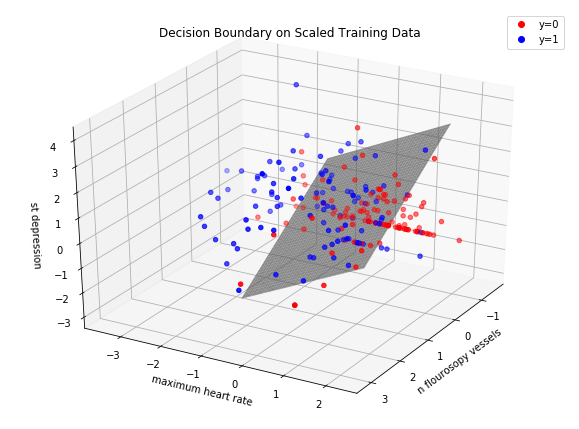

[0.8864318514407425, -0.5943796722796093, 0.7526560003268722]


In [95]:
colors = ['red','blue']
y_fig=y_train.squeeze()

fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(X_pipe[:,0], X_pipe[:,1], X_pipe[:,2], c=y_fig,cmap=matplotlib.colors.ListedColormap(colors))

scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
ax.legend([scatter1_proxy, scatter2_proxy], ['y=0', 'y=1'], numpoints = 1)

z = lambda x,y: (-b-thetas[0]*x-thetas[1]*y) / thetas[2]

tmp = np.linspace(-1.5,1.5,227)
x_tmp, y_tmp = np.meshgrid(tmp,tmp)
ax.plot_surface(x_tmp, y_tmp, z(x_tmp,y_tmp), color='grey', alpha=0.7)

plt.xlabel('n flourosopy vessels')
plt.ylabel('maximum heart rate')
ax.set_zlabel('st depression')
ax.view_init(30, 30)
ax.set_title('Decision Boundary on Scaled Training Data')


plt.show()

print(thetas)

## Training / Testing Stochastic Gradient Descent 

Below, we define our SGD algorithm and visualise over 20 iterations:

0.7650447763412499
-0.5361694328743642
0.8931071067645681
-0.13906299386252535


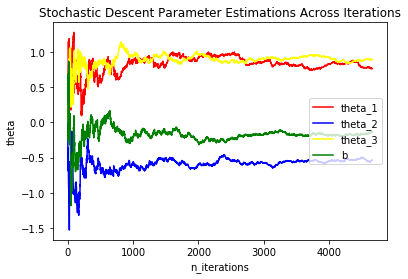

In [248]:
def learning_schedule(t):
    return t0/(t+t1)

def SGD_train(X,y, n_iterations):

    W=np.zeros((X.shape[1],1))
    Ws=np.empty((X.shape[1],0))
    b=np.zeros((1,1))
    bs=np.empty((1,0))
    losses=[]

    m=X_train.shape[0]
    
    for n in range(n_iterations):
        for i in range(m):

            random_index=np.random.randint(m)
            xi=X_pipe[random_index:random_index+1]
            yi=y_train[random_index:random_index+1]
            eta=learning_schedule(n*m+i)

            Z=np.matmul(xi, W)+ b
            A=sigmoid(Z)

            dz=A-yi
            dw=np.matmul(xi.T, dz)
            db=np.sum(dz)

            W=W-eta*dw
            b=b-eta*db

            Ws= np.concatenate((Ws, W), axis=1)
            bs=np.concatenate((bs, b), axis=1)       

    df=pd.DataFrame(Ws.T)
    df.columns=[ [('theta_' + str(num+1)) for num in range(3)]]
    df['b']=bs.T
    return df


def visualise_sgd(df):
   
    plt.plot(df.loc[:, 'theta_1'], color='red', label='theta_1')
    plt.plot(df.loc[:, 'theta_2'], color='blue', label='theta_2')
    plt.plot(df.loc[:, 'theta_3'], color='yellow', label='theta_3')
    plt.plot(df.loc[:, 'b'], color='green', label='b')   
    plt.legend(loc='right')
    plt.title('Stochastic Descent Parameter Estimations Across Iterations')
    plt.xlabel('n_iterations')
    plt.ylabel('theta')

t0, t1=25, 50

df=SGD_train(X=X_pipe, y=y_train, n_iterations=20)

visualise_sgd(df)    

theta_1=float(df["theta_1"].iloc[-1, :])
theta_2=float(df["theta_2"].iloc[-1, :])
theta_3=float(df["theta_3"].iloc[-1, :])
b=float(df["b"].iloc[-1, :])

print(theta_1)
print(theta_2)
print(theta_3)
print(b)

The above is behaving roughly as expected: each curve converges towards a value but never quite settles, wobbling around the minima indefinitely. We end up with estimations that are proportional to those obtained via the batch method but only somewhat near. Checking performance metrics:


In [249]:
# new list of parameters
thetas=[theta_1, theta_2, theta_3]

#calling
X_decision_df= gradient_descent_fit(X_test_pipe, y_test, thetas, 0.5)  
key_performance(X_decision_df)


accuracy:  0.8142857142857143
precision:  0.7142857142857143
recall:  0.8928571428571429
F1 score:  0.7936507936507937


Actually quite good! Precision is the same, and accuracy, recall and F1 score are higher. This is clearly a comparable estimator in terms of results, with the added bonus that it functions better time-wise over large datasets. 


The 't0' to 't1' hyperparamters in the learning schedule respectively determine the overall learning rate and how quickly the learning rate decreases in inverse proportion to the iteration. The below tests a few values:


accuracy:  0.8
precision:  0.7142857142857143
recall:  0.8620689655172413
F1 score:  0.7812500000000001


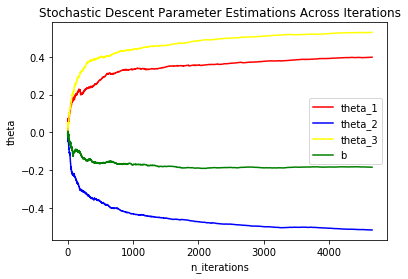

In [250]:
#inverse of iteration
t0, t1=1, 50

df=SGD_train(X=X_pipe, y=y_train, n_iterations=20)

visualise_sgd(df)    

theta_1=float(df["theta_1"].iloc[-1, :])
theta_2=float(df["theta_2"].iloc[-1, :])
theta_3=float(df["theta_3"].iloc[-1, :])
b=float(df["b"].iloc[-1, :])

# new list of parameters
thetas=[theta_1, theta_2, theta_3]

#calling
X_decision_df= gradient_descent_fit(X_test_pipe, y_test, thetas, 0.5)  
key_performance(X_decision_df)


With a low t0 value, a couple of the parameters appear to converge too slowly. 

accuracy:  0.7857142857142857
precision:  0.6857142857142857
recall:  0.8571428571428571
F1 score:  0.7619047619047619


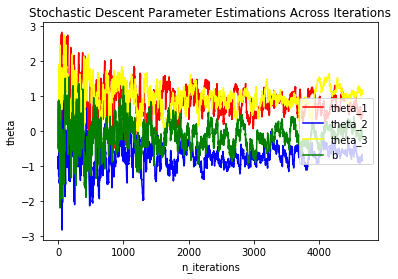

In [264]:
#inverse of iteration
t0, t1=500, 500
df=SGD_train(X=X_pipe, y=y_train, n_iterations=20)

visualise_sgd(df)    

theta_1=float(df["theta_1"].iloc[-1, :])
theta_2=float(df["theta_2"].iloc[-1, :])
theta_3=float(df["theta_3"].iloc[-1, :])
b=float(df["b"].iloc[-1, :])

# new list of parameters
thetas=[theta_1, theta_2, theta_3]

#calling
X_decision_df= gradient_descent_fit(X_test_pipe, y_test, thetas, 0.5)  
key_performance(X_decision_df)

With the ratio of t0 to t1 nearer to 1, the learning schedule doesn't decline quickly enough and the algorithm never settles down. 

In [ ]:
def threshold_test(test_data, y_test):